# intro

The point of this file will be to identify the water masses by their T-S values and make a big 'ol file of the indices as we did in the previous one.

In [1]:
# we saved the full file at : file_path = "/scratch/mmurakami/WAOM/drifter_data_all.nc"


In [1]:
# import the packages
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import gsw

In [2]:
import shapely.geometry as sg
from shapely import Point


In [3]:
# coding 0 AABW, 1 MCDW, 2 ISW, 3 DSW, 4 AASW, 5 other, 6 HSSW, 7 is LSSW, 8 is mSW
def wmt_categorize2(temp,Freez_temp,salt,enddens_allvals,depth,dens):
    mass = np.array([],dtype=int)
    highd = 0
    lowd = 0
    for t,tf,s,rho,d,pd in zip(temp,Freez_temp,salt,enddens_allvals,depth,dens):
        # aabw
        if d <= -1066.8 and rho >= 28.27 and s>=34.6 and s<=34.75 and t<=0:
            mass = np.append(mass,0)
            
        # shelf waters
        #mSW
        elif rho >= 28.27 and s >=34.5 and t>(tf+0.1) and t<-1.7 and (d>-1000):
            mass = np.append(mass,8)
            
        # dsw
        elif s>=34.5 and t>=(tf-0.5) and t<=(tf+0.1) and rho>=28.27:
            mass = np.append(mass,3)
        # hssw is before we reach conditions for dsw
        elif pd>=28 and (s>34.5) and (d>-1000) and t<-1.7 and t>-2: # from Yoon, Portela and 
            # add it to the list of indices of interest
            mass = np.append(mass,6)
        # lssw is from conditions too low salinity for dsw
        elif pd >= 28 and s<=34.5 and (d>-1000) and t<-1.7 and t>-2:
            mass = np.append(mass,7)
        
        # other water masses defined from portela
        # mcdw
        elif t>(tf+0.1) and rho>=28 and rho<=28.27:                             # modified tf
            mass = np.append(mass,1)
        # aasw
        elif s<=34.5 and t>=tf and rho<28:                                          # modified s
            mass = np.append(mass,4)
        # isw (also defined in yoon)
        elif t<(tf) and d<-100:                                                    # modified tf
            mass = np.append(mass,2)
        
        # other
        else:
            #if rho>28 and t>tf:
            mass = np.append(mass,5)
                
            #print(t,tf,s,rho,d,pd)
            #else:
            #    do = 1
                #print(t,tf,s,rho,d)
    return(mass)

In [4]:
# load the dataset
filename = "/scratch/mmurakami/WAOM/drifter_data_all_withdepth.nc"
ds = xr.load_dataset(filename)

In [5]:
ds

<xarray.Dataset>
Dimensions:  (time: 194353, drifter: 3895, driftr: 3895)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 ... 194348 194349 194350 194351 194352
  * drifter  (drifter) int64 0 1 2 3 4 5 6 ... 3889 3890 3891 3892 3893 3894
Dimensions without coordinates: driftr
Data variables:
    Xgrid    (time, drifter) float32 518.0 518.0 518.0 518.0 ... nan nan nan nan
    Ygrid    (time, drifter) float32 443.0 443.0 443.0 443.0 ... nan nan nan nan
    Zgrid    (time, drifter) float32 30.63 30.63 30.63 30.63 ... nan nan nan nan
    rho      (time, drifter) float32 27.36 27.43 27.52 27.68 ... nan nan nan nan
    temp     (time, drifter) float32 -1.539 -1.524 -1.707 -1.862 ... nan nan nan
    salt     (time, drifter) float32 33.98 34.07 34.17 34.37 ... nan nan nan nan
    depth    (time, driftr) float32 -2.649 -2.525 -2.646 -2.513 ... nan nan nan

# do a plot of the times just to test we did this right

In [6]:
times = np.loadtxt("times.txt") # timesteps
months = np.loadtxt("months.txt")

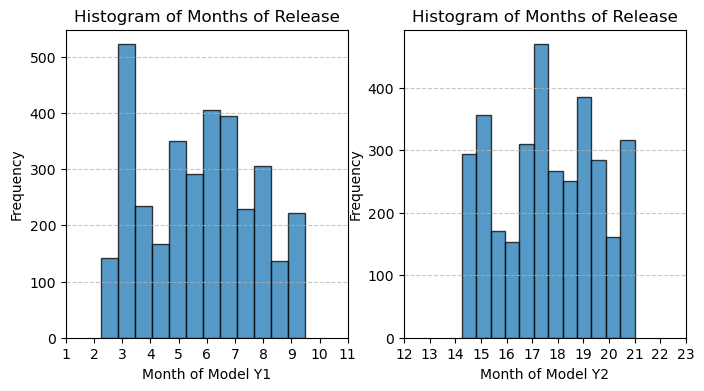

In [7]:
a = months[months>12]
b = months[months<12]

fig = plt.figure(figsize=(8,4))

ax = plt.subplot(121)
ax.hist(b, bins=12, edgecolor='black', alpha=0.75)
ax.set_xlabel('Month of Model Y1')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Months of Release')
ax.set_xticks(range(1, 12))  # Show all days in a month
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax = plt.subplot(122)
ax.hist(a, bins=12, edgecolor='black', alpha=0.75)
ax.set_xlabel('Month of Model Y2')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Months of Release')
ax.set_xticks(range(12, 24))  # Show all days in a month
ax.grid(axis='y', linestyle='--', alpha=0.7)

# define the water masses in TS space

tmin, tmax, smin, smax sizes=, -3.3 3.63 30.69 38.38


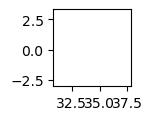

In [6]:
# add the polygons and the points
smin = 31 - (0.01 * 31)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38. + (0.01 * 38.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -3 + (0.1 * -3)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 3.3 + (0.1 * 3.3)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 30
# Create empty grid of zeros
dens2 = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti1 = np.linspace(-3,3.3,ydim)
si1 = np.linspace(31,38,xdim)
Freez_temp = gsw.CT_freezing(si1,0,0)

Si, Ti = np.meshgrid(si1, ti1, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens2[j,i]=gsw.rho(si1[i],ti1[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens2 - 1000

# convert to practical/potential
long = 73.5089
lat = -66.8245
ti = gsw.pt_from_CT(si1,ti1)
si = gsw.SP_from_SA(si1,0,long,lat)

# create the polygons for the next plot
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)

# add aabw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.2f")
# get the dens2ity vertices
p = cs.collections[0].get_paths()[0]
v = p.vertices
# get the TS vertices
s = np.array([34.5,36,36,34.5,34.5])
t = np.array([-3,-3,0.1,0.1,-3])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
a = sg.Polygon(v)
b = sg.Polygon(b)
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[0.1,0.1,max(ft)])
c = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(c)
d = a.intersection(b)
aabw = c.intersection(d)

# find the winter water values
cs = ax.contourf(si, ti, dens2, levels=[27.55,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-1.5,-1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
ww = a.intersection(b)

# find the mcdw values
cs = ax.contourf(si, ti, dens2, levels=[27.73,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[1.5,1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
mcdw = a.intersection(b)

# find the dsw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
# ftmax = Freez_temp+0.1
# ftmin = Freez_temp-0.5
# ft = np.append(ftmax,np.flip(ftmin))
# si2 = si.copy()
# si2 = np.append(si2,np.flip(si2))
# b = np.array([[a,b] for a,b in zip(si2,ft)])
sx = np.array([35,35,34.5,34.5])
sy = np.array([-3,-1.7,-1.7,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
#dsw = b.intersection(c)
dsw = b.intersection(a)

# find the aasw values
cs = ax.contourf(si, ti, dens2, levels=[24,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in dens2ity
sx = np.array([34.5,34.5,31,31])
sy = np.array([-3,3.5,3.5,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aasw = d.intersection(a)

# find the msw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp + 0.1
ft = np.append(ft,[-0.4,-0.4])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
#dsw = b.intersection(c)
msw = c.intersection(a)
msw = msw.difference(dsw)

# add ISW values
cs = ax.contourf(si, ti, dens2, levels=[25,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp# - 0.05
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-3,-3,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
b = sg.Polygon(b)
isw = b.intersection(a)
#isw = isw.difference(dsw)
isw = isw.difference(aabw)
#ucdw = ucdw.difference(mcdw)
aasw = aasw.difference(ww)
#aasw = aasw.difference(ucdw)

# find the aaiw values
cs = ax.contourf(si, ti, dens2, levels=[27.2,27.4],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in dens2ity
sx = np.array([34.6,34.6,32,32])
sy = np.array([2,3.5,3.5,2])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aaiw = d.intersection(a)

In [7]:
T_wdw = -2.05
S_wdw = 34.5
Lf = 334 # kJ/kg
Cp = gsw.cp_t_exact(S_wdw,T_wdw,0)/1000
print(Cp)

Tgade = T_wdw + (Lf/Cp)*(1 - (S_wdw/si))

3.9907110140574806


Text(0, 0.5, 'Potential Temperature')

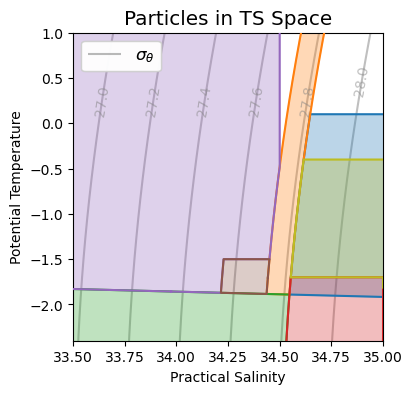

In [8]:
#POLYGONS
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-2.4,1)
plt.xlim(33.5,35)
#plt.xlim(xedges[0], xedges[-1])
#plt.ylim(yedges[0], yedges[-1])
shapes = np.array([])
shapelabels = np.array([])
plt.rcParams.update({'font.size': 12})

# add the potential density lines
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.5,levels=np.arange(24,28.5,0.2))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

# AABW values
x, y = aabw.exterior.xy
aabw2 = plt.plot(x, y,label="AABW",color="tab:blue",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,aabw2)
shapelabels = np.append(shapelabels,"AABW*")
# MCDW values
x, y = mcdw.exterior.xy
mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,mcdw2)
shapelabels = np.append(shapelabels,"mCDW")

# # ISW values
x, y = isw.exterior.xy
isw2 = plt.plot(x, y,label="ISW",color="tab:green",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:green")
shapes = np.append(shapes,isw2)
shapelabels = np.append(shapelabels,"ISW")
# # DSW values
x, y = dsw.exterior.xy
dsw2 = plt.plot(x, y,label="DSW",color="tab:red",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,dsw2)
shapelabels = np.append(shapelabels,"DSW")

# # MSW values
x, y = msw.exterior.xy
msw2 = plt.plot(x, y,label="mSW*",color="tab:olive",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:olive")
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"mSW*")

# # AASW values
x, y = aasw.exterior.xy
aasw2 = plt.plot(x, y,label="AASW",color="tab:purple",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,aasw2)
shapelabels = np.append(shapelabels,"AASW")

# # WW values
x, y = ww.exterior.xy
ww2 = plt.plot(x, y,label="WW",color="tab:brown",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:brown")
shapes = np.append(shapes,ww2)
shapelabels = np.append(shapelabels,"WW")

# labels and plot
legend1 = plt.legend(h,l, loc=2)
plt.gca().add_artist(legend1)
#plt.legend(shapes,shapelabels, loc=1)
# plt.scatter(salt.flatten(),temp.flatten(),s=0.1)

# plt.title("Neutral and potential density of water masses")
plt.title("Particles in TS Space")
plt.xlabel('Practical Salinity')
plt.ylabel('Potential Temperature')

# define the arrays from the ds for temp, salt, depth

In [9]:
temp = ds['temp'].values

In [10]:
salt = ds['salt'].values

In [11]:
depth = ds['depth'].values

In [13]:
# coding 0 AABW, 1 MCDW, 2 ISW, 3 DSW, 4 AASW, 5 WW, 6 mSW, 7 beached
# use potential T and practical S, 
def wmt_categorize2(temp,salt,depth,aabw,mcdw,isw,dsw,aasw,ww,msw):
#     print(temp.shape,Freez_temp.shape,salt.shape,enddens_allvals.shape,depth.shape,dens.shape)
    mass = np.array([],dtype=int)

    points = np.array([Point(s, t) for s, t in zip(salt, temp)])

    for t,s,d in zip(temp,salt,depth):

        # beached
        if np.isnan(t) or np.isnan(s):
            mass = np.append(mass,7)
        else:
            point = Point(s,t)
            
            # aabw
            if d<-1000 and aabw.contains(point):
                mass = np.append(mass,0)
            elif d>-1000 and msw.contains(point):
                mass = np.append(mass,6)
                
            # mcdw
            elif mcdw.contains(point): # or aabw.contains(point):                             # modified tf
                mass = np.append(mass,1)
    
            # dsw
            elif dsw.contains(point):
                #elif s>=34.5 and t>=(tf-0.5) and t<=(tf+0.1) and rho>=27.68:
                mass = np.append(mass,3)
                
            # isw (also defined in yoon)
            elif isw.contains(point):                                                    # modified tf
                mass = np.append(mass,2)
            # other water masses defined from portela
            # aasw
            elif aasw.contains(point):                                          # modified s
                mass = np.append(mass,4)
            # ww
            elif ww.contains(point):
                mass = np.append(mass,5)
            
            # other shelf waters
            elif aabw.contains(point):
                mass = np.append(mass,6)
            
            else:
                mass = np.append(mass,1)
        
    return(mass)

In [14]:
arr = wmt_categorize2(temp[1],salt[1],depth[1],aabw,mcdw,isw,dsw,aasw,ww,msw)
# arr = wmt_categorize2(temp[0],salt[0],depth[0],aabw,mcdw,isw,dsw,aasw,ww,msw)

unique_values, counts = np.unique(arr, return_counts=True)
names = ['AABW', 'MCDW', 'ISW', 'DSW', 'AASW', 'WW', 'mSW','beached']
for i,j in zip(unique_values,counts):
    print(names[int(i)],j)

MCDW 1165
ISW 11
DSW 617
AASW 1466
WW 469
mSW 167


In [95]:
# faster version thanks to gpt
import time

def wmt_categorize2(temp, salt, depth, aabw, mcdw, isw, dsw, aasw, ww, msw):
    shape = temp.shape  # Store original shape
    temp = temp.ravel()
    salt = salt.ravel()
    depth = depth.ravel()

    # Initialize mass array with default value (e.g., 1)
    mass = np.full(temp.shape, 1, dtype=int)

    # Beached (NaNs)
    nan_mask = np.isnan(temp) | np.isnan(salt)
    mass[nan_mask] = 7

    # Generate array of Point objects
    points = np.array([Point(s, t) for s, t in zip(salt, temp)])

    # Apply polygon checks
    deep_mask = depth < -1000
    shallow_mask = depth > -1000

    # timing
    start_time = time.time()
    numpts = depth.shape[0]
    

    # Using explicit loops for validation
    for i, (p, d) in enumerate(zip(points, depth)):
        if i%1000000 == 0:
            print(i,"/",numpts,"in",(time.time()-start_time)/60)
        
        if nan_mask[i]:
            continue
        elif d < -1000 and aabw.contains(p):
            mass[i] = 0
        elif d > -1000 and msw.contains(p):
            mass[i] = 6
        elif mcdw.contains(p):
            mass[i] = 1
        elif dsw.contains(p):
            mass[i] = 3
        elif isw.contains(p):
            mass[i] = 2
        elif aasw.contains(p):
            mass[i] = 4
        elif ww.contains(p):
            mass[i] = 5
        elif aabw.contains(p):
            mass[i] = 6  # Overwriting if another condition matched

    return mass.reshape(shape)


In [15]:
arr = wmt_categorize2(temp[1],salt[1],depth[1],aabw,mcdw,isw,dsw,aasw,ww,msw)

unique_values, counts = np.unique(arr, return_counts=True)
names = ['AABW', 'MCDW', 'ISW', 'DSW', 'AASW', 'WW', 'mSW','beached']
for i,j in zip(unique_values,counts):
    print(names[int(i)],j)

MCDW 1165
ISW 11
DSW 617
AASW 1466
WW 469
mSW 167


In [17]:
arr = wmt_categorize2(temp[-100],salt[-100],depth[-100],aabw,mcdw,isw,dsw,aasw,ww,msw)
# np.savez_compressed("/scratch/mmurakami/WAOM/wmt_categories.npz", mass_array=mass)
unique_values, counts = np.unique(arr, return_counts=True)
names = ['AABW', 'MCDW', 'ISW', 'DSW', 'AASW', 'WW', 'mSW','beached']
for i,j in zip(unique_values,counts):
    print(names[int(i)],j)

AABW 10
MCDW 14
AASW 6
beached 3865


In [132]:
# get the last valid index for these
last_valid_idx = np.argmax(~np.isnan(temp)[::-1, :], axis=0)

# Convert to actual indices (since we reversed the array)
last_valid_idx = temp.shape[0] - 1 - last_valid_idx

print(last_valid_idx)  # This gives the last valid index for each column

[182915 137196 181571 ... 142597 177541 150661]


In [138]:
tempa = np.array([])
salta = np.array([])
deptha = np.array([])

x = 0
for i in last_valid_idx:
    tempa = np.append(tempa,temp[i,x])
    salta = np.append(salta,salt[i,x])
    deptha = np.append(tempa,depth[i,x])

    x += 1

In [142]:
arr = wmt_categorize2(tempa,salta,deptha,aabw,mcdw,isw,dsw,aasw,ww,msw)
arr = wmt_categorize2(temp[170000],salt[170000],depth[170000],aabw,mcdw,isw,dsw,aasw,ww,msw)


unique_values, counts = np.unique(arr, return_counts=True)
names = ['AABW', 'MCDW', 'ISW', 'DSW', 'AASW', 'WW', 'mSW','beached']
for i,j in zip(unique_values,counts):
    print(names[int(i)],j)

0 / 3896 in 1.8676122029622396e-07
0 / 3895 in 1.1523564656575521e-07
AABW 408
MCDW 528
ISW 34
AASW 288
WW 30
mSW 4
beached 2603


In [131]:
u = 149990
u = 130000
temp[u][~np.isnan(temp[u])].shape

(3583,)

In [20]:
arr = wmt_categorize2(temp[1],salt[1],depth[1],aabw,mcdw,isw,dsw,aasw,ww,msw)
# np.savez_compressed("/scratch/mmurakami/WAOM/wmt_categories.npz", mass_array=mass)
unique_values, counts = np.unique(arr, return_counts=True)
names = ['AABW', 'MCDW', 'ISW', 'DSW', 'AASW', 'WW', 'mSW','beached']
for i,j in zip(unique_values,counts):
    print(names[int(i)],j)

MCDW 1165
ISW 11
DSW 617
AASW 1466
WW 469
mSW 167


In [21]:
dswi = np.where(arr == 3)
mcdwi = np.where(arr == 1)
aaswi = np.where(arr == 4)
aabwi = np.where(arr == 0)

# tester scatter plot for debugging if necessary

Text(0, 0.5, 'Potential Temperature')

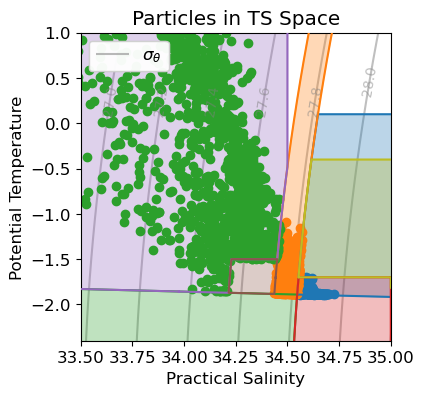

In [23]:
#POLYGONS
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
plt.ylim(-2.4,1)
plt.xlim(33.5,35)
#plt.xlim(xedges[0], xedges[-1])
#plt.ylim(yedges[0], yedges[-1])
shapes = np.array([])
shapelabels = np.array([])
plt.rcParams.update({'font.size': 12})

# add the potential density lines
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.5,levels=np.arange(24,28.5,0.2))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
h, l = cs.legend_elements()
h = np.array([h[0]],dtype=object)
l = np.array(["$\sigma_{θ}$"])

# AABW values
x, y = aabw.exterior.xy
aabw2 = plt.plot(x, y,label="AABW",color="tab:blue",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:blue")
shapes = np.append(shapes,aabw2)
shapelabels = np.append(shapelabels,"AABW*")
# MCDW values
x, y = mcdw.exterior.xy
mcdw2 = plt.plot(x, y,label="mCDW",color="tab:orange",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:orange")
shapes = np.append(shapes,mcdw2)
shapelabels = np.append(shapelabels,"mCDW")

# # ISW values
x, y = isw.exterior.xy
isw2 = plt.plot(x, y,label="ISW",color="tab:green",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:green")
shapes = np.append(shapes,isw2)
shapelabels = np.append(shapelabels,"ISW")
# # DSW values
x, y = dsw.exterior.xy
dsw2 = plt.plot(x, y,label="DSW",color="tab:red",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:red")
shapes = np.append(shapes,dsw2)
shapelabels = np.append(shapelabels,"DSW")

# # MSW values
x, y = msw.exterior.xy
msw2 = plt.plot(x, y,label="mSW*",color="tab:olive",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:olive")
shapes = np.append(shapes,msw2)
shapelabels = np.append(shapelabels,"mSW*")

# # AASW values
x, y = aasw.exterior.xy
aasw2 = plt.plot(x, y,label="AASW",color="tab:purple",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:purple")
shapes = np.append(shapes,aasw2)
shapelabels = np.append(shapelabels,"AASW")

# # WW values
x, y = ww.exterior.xy
ww2 = plt.plot(x, y,label="WW",color="tab:brown",zorder=5)
plt.fill(x, y,alpha=0.3,color="tab:brown")
shapes = np.append(shapes,ww2)
shapelabels = np.append(shapelabels,"WW")

# labels and plot
legend1 = plt.legend(h,l, loc=2)
plt.gca().add_artist(legend1)
#plt.legend(shapes,shapelabels, loc=1)
# plt.scatter(salt.flatten(),temp.flatten(),s=0.1)

t = 1
plt.scatter(salt[1][dswi],temp[1][dswi])
plt.scatter(salt[1][mcdwi],temp[1][mcdwi])
plt.scatter(salt[1][aaswi],temp[1][aaswi])
plt.scatter(salt[1][aabwi],temp[1][aabwi])


# plt.title("Neutral and potential density of water masses")
plt.title("Particles in TS Space")
plt.xlabel('Practical Salinity')
plt.ylabel('Potential Temperature')

# label starting and ending values for the 4.5 years and do the clustering